In [ ]:
!wget https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
!unzip -qq synthetic-data.zip
!pip install torch_snippets torch_summary editdistance

In [ ]:
from torch_snippets import *
from torchsummary import summary
import editdistance
from sklearn.model_selection import train_test_split

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fname2label = lambda name: str(name).split('@')[0].split('/')[1]
images = Glob('synthetic-data')

2021-10-07 19:03:34.014 | INFO     | torch_snippets.paths:inner:24 - 25132 files found at synthetic-data


In [ ]:
vocab = 'QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'
BATCH, TIMESTEP, VOCAB = 64, 32, len(vocab)
H, W = 32, 128

In [ ]:
class OCRDataset(Dataset):

    def __init__(self, items, vocab=vocab, preprocess_shape=(H,W), timesteps=TIMESTEP):
        super().__init__()
        self.items = items
        self.charList = {ix+1:ch for ix,ch in enumerate(vocab)}
        self.charList.update({0: '`'})
        self.invCharList = {v:k for k,v in self.charList.items()}
        self.ts = timesteps

    def __len__(self):
        return len(self.items)

    def sample(self):
        return self[randint(len(self))]

    def __getitem__(self, ix):
        item = self.items[ix]
        image = cv2.imread(str(item), 0)
        label = fname2label(item)
        return image, label

    def collate_fn(self, batch):
        images, labels, label_lengths, label_vectors, input_lengths = [], [], [], [], []
        for image, label in batch:
            images.append(torch.Tensor(self.preprocess(image))[None,None])
            label_lengths.append(len(label))
            labels.append(label)
            label_vectors.append(self.str2vec(label))
            input_lengths.append(self.ts)
        images = torch.cat(images).float().to(device)
        label_lengths = torch.Tensor(label_lengths).long().to(device)
        label_vectors = torch.Tensor(label_vectors).long().to(device)
        input_lengths = torch.Tensor(input_lengths).long().to(device)
        return images, label_vectors, label_lengths, input_lengths, labels

    def str2vec(self, string, pad=True):
        string = ''.join([s for s in string if s in self.invCharList])
        val = list(map(lambda x: self.invCharList[x], string)) 
        if pad:
            while len(val) < self.ts:
                val.append(0)
        return val
    
    def preprocess(self, img, shape=(32,128)):
        target = np.ones(shape)*255
        try:
            H, W = shape
            h, w = img.shape
            fx = H/h
            fy = W/w
            f = min(fx, fy)
            _h = int(h*f)
            _w = int(w*f)
            _img = cv2.resize(img, (_w,_h))
            target[:_h,:_w] = _img
        except:
            pass
        return (255-target)/255

    def decoder_chars(self, pred):
        decoded = ""
        last = ""
        pred = pred.cpu().detach().numpy()
        for i in range(len(pred)):
            k = np.argmax(pred[i])
            if k > 0 and self.charList[k] != last:
                last = self.charList[k]
                decoded = decoded + last
            elif k > 0 and self.charList[k] == last:
                continue
            else:
                last = ""
        return decoded.replace(" "," ")

    def wer(self, preds, labels):
        c = 0
        for p, l in zip(preds, labels):
            c += p.lower().strip() != l.lower().strip()
        return round(c/len(preds), 4)
    
    def cer(self, preds, labels):
        c, d = [], []
        for p, l in zip(preds, labels):
            c.append(editdistance.eval(p, l) / len(l))
        return round(np.mean(c), 4)

    def evaluate(self, model, ims, labels, lower=False):
        model.eval()
        preds = model(ims).permute(1,0,2) 
        preds = [self.decoder_chars(pred) for pred in preds]
        return {'char-error-rate': self.cer(preds, labels),
                'word-error-rate': self.wer(preds, labels),
                'char-accuracy' : 1 - self.cer(preds, labels),
                'word-accuracy' : 1 - self.wer(preds, labels)}

In [ ]:
train_items, valid_items = train_test_split(Glob('synthetic-data'), test_size=0.2, random_state=1)
train_dataset = OCRDataset(train_items)
valid_dataset = OCRDataset(valid_items)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, collate_fn=train_dataset.collate_fn, 
                              drop_last=True, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH, collate_fn=valid_dataset.collate_fn, 
                              drop_last=True)

2021-10-07 19:09:26.364 | INFO     | torch_snippets.paths:inner:24 - 25132 files found at synthetic-data


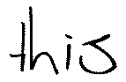

In [ ]:
img, _ = valid_dataset[0]
show(img)

In [ ]:
from torch_snippets import Reshape, Permute

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, ni, no, ks=3, st=1, padding=1, pool=2, drop=0.2):
        super().__init__()
        self.ks = ks
        self.block = nn.Sequential(
            nn.Conv2d(ni, no, kernel_size=ks, stride=st, padding=padding),
            nn.BatchNorm2d(no, momentum=0.3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool),
            nn.Dropout2d(drop)
        )
    def forward(self, x):
        return self.block(x)

class Ocr(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.model = nn.Sequential(
            BasicBlock( 1, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 256, pool=(4,2)),
            Reshape(-1, 256, 32),
            Permute(2, 0, 1)
        )
        self.rnn = nn.Sequential(
            nn.LSTM(256, 256, num_layers=2, dropout=0.2, bidirectional=True),
        )
        self.classification = nn.Sequential(
            nn.Linear(512, vocab+1),
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        x = self.model(x)
        x, lstm_states = self.rnn(x)
        y = self.classification(x)
        return y

def ctc(log_probs, target, input_lengths, target_lengths, blank=0):
    loss = nn.CTCLoss(blank=blank, zero_infinity=True)
    ctc_loss = loss(log_probs, target, input_lengths, target_lengths)
    return ctc_loss

In [ ]:
model = Ocr(len(vocab)).to(device)
summary(model, torch.zeros((1,1,32,128)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 53]               --
|    └─Linear: 2-7                       [-1, 1, 53]             

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 53]               --
|    └─Linear: 2-7                       [-1, 1, 53]             

In [ ]:
def train_batch(data, model, optimizer, criterion):
    model.train()
    imgs, targets, label_lens, input_lens, labels = data
    optimizer.zero_grad()
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    loss.backward()
    optimizer.step()
    results = train_dataset.evaluate(model, imgs.to(device), labels)
    return loss, results

@torch.no_grad()
def validate_batch(data, model):
    model.eval()
    imgs, targets, label_lens, input_lens, labels = data
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    return loss, valid_dataset.evaluate(model, imgs.to(device), labels)

In [ ]:
criterion = ctc
optimizer = optim.AdamW(model.parameters(), lr=3e-3)
# scheduler?
epochs = 50
log = Report(epochs)

In [ ]:
for epoch in range(epochs):
    N = len(train_dataloader)
    for ix, data in enumerate(train_dataloader):
        pos = epoch + (ix + 1) / N
        loss, results = train_batch(data, model, optimizer, criterion)
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos, train_loss=loss, train_char_accuracy=ca, train_word_accuracy=wa, end='\r')
    val_results = []
    N = len(valid_dataloader)
    for ix, data in enumerate(valid_dataloader):
        pos = epoch + (ix + 1) / N
        loss, results = validate_batch(data, model)
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos, valid_loss=loss, valid_char_accuracy=ca, valid_word_accuracy=wa, end='\r')
    log.report_avgs(epoch + 1)
    print()
    for i in range(5):
        img, label = valid_dataset.sample()
        _img = torch.Tensor(valid_dataset.preprocess(img)[None, None]).to(device)
        pred = model(_img)[:, 0, :]
        pred = train_dataset.decoder_chars(pred)
        print(f'Prediction: "{pred}", Ground Truth: "{label}"')
    print()

EPOCH: 1.000	train_loss: 3.334	train_char_accuracy: 0.006	train_word_accuracy: 0.000	valid_loss: 3.104	valid_char_accuracy: 0.069	valid_word_accuracy: 0.000	(1911.74s - 93675.07s remaining)

Prediction: "a", Ground Truth: "wish"
Prediction: "a", Ground Truth: "eat"
Prediction: "a", Ground Truth: "idea"
Prediction: "s", Ground Truth: "TV"
Prediction: "t", Ground Truth: "during"

EPOCH: 2.000	train_loss: 2.872	train_char_accuracy: 0.156	train_word_accuracy: 0.001	valid_loss: 2.581	valid_char_accuracy: 0.251	valid_word_accuracy: 0.002	(3376.28s - 81030.82s remaining)

Prediction: "ce", Ground Truth: "agent"
Prediction: "tee", Ground Truth: "drop"
Prediction: "tine", Ground Truth: "time"
Prediction: "mete", Ground Truth: "reality"
Prediction: "rete", Ground Truth: "return"

EPOCH: 2.522	train_loss: 2.312	train_char_accuracy: 0.369	train_word_accuracy: 0.016	(4055.13s - 76330.58s remaining)